In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy

In [2]:
def get_matches(sift, left_img, right_img):
    
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(left_img, cv2.COLOR_BGRA2GRAY),None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(right_img, cv2.COLOR_BGRA2GRAY),None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params) 
    matches = flann.knnMatch(des1,des2,k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m) 
            
    left_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    right_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    return left_pts, right_pts

In [3]:
def gen_f(left_pts, right_pts):
    
    a_mat = np.array([])
    for i in range(len(left_pts)):
        
        ul = left_pts[i][0]    
        vl = left_pts[i][1]    
        
        ur = right_pts[i][0]    
        vr = right_pts[i][1]    
        
        a_entry = np.array(
            [
                [ul*ur, ul*vr, ul, vl*ur, vl*vr, vl, ur, vr, 1]
            ]
        )
        
        if a_mat.shape[0] == 0:
            a_mat = a_entry        
        else:
            a_mat = np.concatenate((a_mat, a_entry))
            
    # use constrained least squares to solve for the best h approx
    aTa = a_mat.T@a_mat
    # choose the eigvec associated with the smallest eigval
    eigvals, eigvecs = np.linalg.eig(aTa)
    # reshape
    f = eigvecs[:, np.argmin(eigvals)].reshape(3, 3)
    return f


In [4]:
def ransac_fundamental(left_pts, right_pts):
    
    print(f"Trying homography config")

    # matrix operation to bulk perform the transformations
    ones = np.ones(shape = (left_pts.shape[0], 1))
    homogeneous_left_pts = np.concatenate((left_pts, ones), axis = 1)
    homogeneous_right_pts = np.concatenate((right_pts, ones), axis = 1)
    
    best_inliers = -1*np.inf
    best_f = None
    thresh = 3 # in pixels
    e = 0.7# inlier ratio
    p = 0.95# success rate
    s = 8 # min points for sample
    
    num_iters = np.log(1-p)/np.log(1-(1-e)**s)
    print(f"Will attempt {num_iters} homographies during RanSaC")

    # for n in range(2):
    for n in range(int(np.round(num_iters))):
        
        rand_idx = np.random.choice(len(left_pts), 8, replace = False)
        
        # gen_homography given a random selection of 4 points
        f = gen_f(left_pts[rand_idx], right_pts[rand_idx])
        u, d, vh = np.linalg.svd(f)
        d[-1] = 0
        f = u@(np.eye(3)*d)@vh
        
        # transform the perform the xl F xr = 0 operation
        err = (homogeneous_left_pts@f)*homogeneous_right_pts
        err = np.abs(np.sum(err, axis = 1))
        inliers = len(np.where(err <= thresh)[0])
        
        if inliers > best_inliers:
            best_inliers = inliers
            best_f = f
    
    return best_f


In [5]:
def gen_h(src_pts, dest_pts):
    
    a_mat = np.array([])
    for i in range(len(src_pts)):
        
        xs = src_pts[i][0]    
        ys = src_pts[i][1]    
        
        xd = dest_pts[i][0]    
        yd = dest_pts[i][1]    
        
        a_entry = np.array(
            [
                [xs, ys, 1, 0, 0, 0, -xs*xd, -ys*xd, -xd],
                [0, 0, 0, xs, ys, 1, -xs*yd, -ys*yd, -yd]
            ]
        )
        if a_mat.shape[0] == 0:
            a_mat = a_entry        
        else:
            a_mat = np.concatenate((a_mat, a_entry))
            
    # use constrained least squares to solve for the best h approx
    aTa = a_mat.T@a_mat
    # choose the eigvec associated with the smallest eigval
    eigvals, eigvecs = np.linalg.eig(aTa)
    # reshape
    h = eigvecs[:, np.argmin(eigvals)].reshape(3, 3)
    return h



In [6]:
def ransac_homography(src_pts, dest_pts):
    
    print(f"Trying homography config")

    # matrix operation to bulk perform the transformations
    ones = np.ones(shape = (src_pts.shape[0], 1))
    homogeneous_src_pts = np.concatenate((src_pts, ones), axis = 1).T
    homogeneous_dest_pts = np.concatenate((dest_pts, ones), axis = 1).T
    
    best_inliers = -1*np.inf
    best_h = None
    thresh = 15 # in pixels
    e = 0.9 # inlier ratio
    p = 0.95 # success rate
    s = 4 # min points for sample
    
    num_iters = np.log(1-p)/np.log(1-(1-e)**s)
    print(f"Will attempt {num_iters} homographies during RanSaC")

    for n in range(int(np.round(num_iters))):
        
        rand_idx = np.random.choice(len(src_pts), 4, replace = False)
        
        # gen_homography given a random selection of 4 points
        h = gen_h(src_pts[rand_idx], dest_pts[rand_idx])
        
        # transform the aptrix of all src points, and adust for the homogeneous coord
        transformed_pts = h@homogeneous_src_pts
        transformed_pts = transformed_pts/transformed_pts[-1, :]
        
        # compute the distance between the transformed coordinate,
        # and the matched coord in the destination image
        distances = (transformed_pts - homogeneous_dest_pts)**2
        distances = np.sum(distances, axis = 0)
        distances = np.sqrt(distances)
            
        # collect the number of inliers
        num_inliers = len(np.where(distances < thresh)[0])
        if num_inliers > best_inliers:
            best_inliers = num_inliers
            best_h = deepcopy(h)

    print(f"Inlier Ratio: {best_inliers/len(src_pts)}")
    return  best_h

In [7]:
def gen_warped_image(src_img, h, calib):

    h_inv = np.linalg.inv(h)


    height = int(calib['height'])
    width = int(calib['width'])

    # create the canvas based on corner locations
    canvas = np.zeros(shape = (height, width, 3), dtype = np.uint8)


    # 1) iterate over all locations in the canvas
    # 2) Transform dest coords back to source coords
    # 3) Check to make sure we actually landed back in the src image
    # 4) If yes then pull the color and set it in the dest location
    for y in range(height):
        if y%100 == height//5:
            print(y)
        for x in range(width):
            
            # go back to dest coords and pull color
            dest_pt = np.array([x, y, 1])
            src_pt = h_inv@dest_pt
            
            src_pt = np.round(src_pt/src_pt[-1])
            src_x = int(src_pt[0])
            src_y = int(src_pt[1])
            
            # bounds checking
            if (src_x < 0 or src_x >= width) or\
                (src_y < 0 or src_y >= height):
                continue
            else:
                # set color
                canvas[y, x] = src_img[src_y, src_x]

    return canvas

In [8]:
def get_calib(dir):

    data = None
    with open(f"{dir}/calib.txt") as infile:
        data = infile.readlines()
    
    calib = {}
    for d in data:
        d = d.strip().split('=')
        if 'cam' in d[0]:
            arr = d[1].replace('[', '').replace(']', '').replace(';', '')
            arr = [float(f) for f in arr.split(' ')]
            arr = np.array(arr).reshape(3, 3)
            calib[d[0]] = arr
        else:
            calib[d[0]] = float(d[1])
        
    return calib

In [9]:
def get_E_R_T(f, calib):

    k = calib['cam0']
    e = np.linalg.inv(k)@f@k

    u, d, vh = np.linalg.svd(e)
    R = vh.T

    T = u@d
    return e, R, T

In [14]:
def plot_epipolar_lines(recified_left, right, left_points, right_pts, h):
    
    l = deepcopy(recified_left)
    r = deepcopy(right)
    
    ones = np.ones(shape=(len(left_points), 1))
    homogeneous_left_pts = np.concatenate((left_points, ones), axis = 1).T
    projected_left_pts = (h@homogeneous_left_pts).T
    
    for i in range(len(left_points)):
        
        xl = int(projected_left_pts[i][0]/projected_left_pts[i][-1])
        yl = int(projected_left_pts[i][1]/projected_left_pts[i][-1])


        if xl < 0 or xl >= 1920:
            continue
        if yl < 0 or yl >= 1080:
            continue
        
        xr = int(right_pts[i][0])
        yr = int(right_pts[i][1])
        
        
        l = cv2.line(l, (0, yl), (1919, yl), [255, 255, 255], 2)
        r = cv2.line(r, (0, yr), (1919, yr), [255, 255, 255], 2)
        
    return l, r
    
    
    

In [11]:
dir = "artroom"
imgs = []
for fname in os.listdir(f"./{dir}/"):
    imgs.append(cv2.imread(f"./{dir}/{fname}"))
    
calib = get_calib(dir)


sift = cv2.SIFT_create()
left_pts, right_pts = get_matches(sift, imgs[0], imgs[1])

f = ransac_fundamental(left_pts, right_pts)

Trying homography config
Will attempt 45658.192310316044 homographies during RanSaC


In [12]:
h = ransac_homography(left_pts, right_pts)
rectified_left_img = gen_warped_image(imgs[0], h, calib)


Trying homography config
Will attempt 29955.824844440736 homographies during RanSaC
Inlier Ratio: 0.8321220930232558


In [15]:
l, r = plot_epipolar_lines(rectified_left_img, imgs[1], left_pts[:100], right_pts[:100], h)

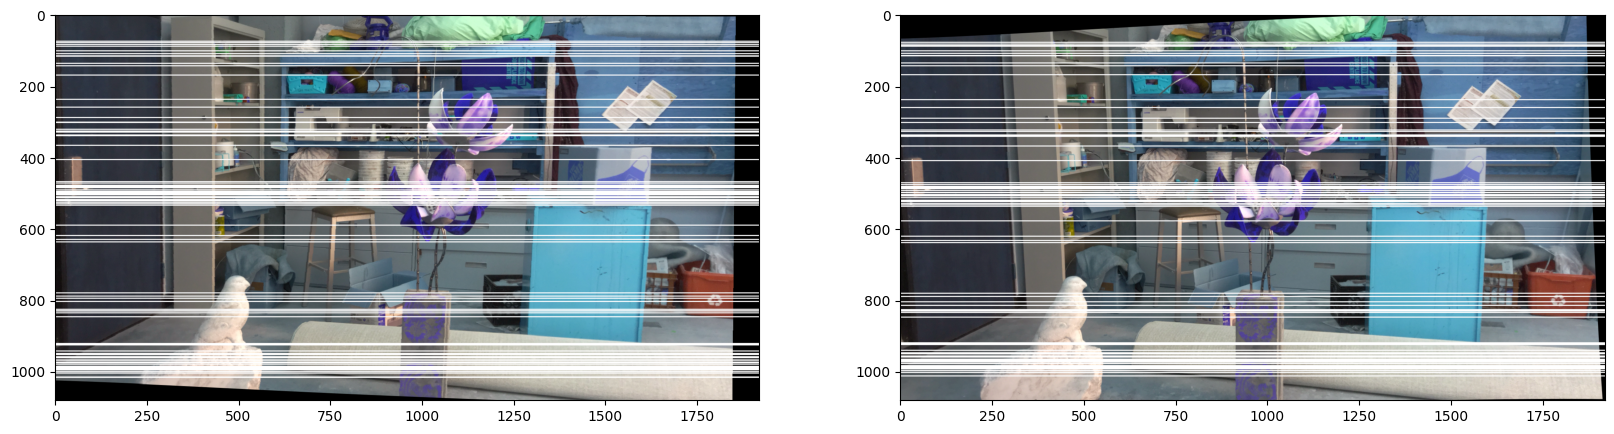

In [16]:


fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(l, aspect = 'auto')
ax[1].imshow(r, aspect = 'auto')